In [1]:
import os

import torch
import wandb
from hydra import compose, initialize
from torch.utils.data import DataLoader

from src.utils.load import load_dvinp
from src.utils.visualize import visualize_dvinp_both

In [2]:
try:
    import torch_directml
    device = torch_directml.device() 
except ImportError:
    device = torch.device("cpu") 

In [3]:
dir = "../models/test" 

In [8]:
with initialize(version_base=None, config_path=dir):
    cfg = compose(config_name="cfg")

    dvinp, trainer = load_dvinp(cfg, device)

    dvinp_path = f"{dir}/dvinp.pth"
    optim_path = f"{dir}/optim.pth"

    if os.path.exists(dvinp_path):
        dvinp_state_dict = torch.load(dvinp_path, map_location=torch.device("cpu"))
        dvinp.load_state_dict(dvinp_state_dict)
        print(f"loaded dvinp from {dvinp_path}")

    if os.path.exists(optim_path):
        optim_state_dict = torch.load(optim_path, map_location=torch.device('cpu'))
        trainer.optimizer.load_state_dict(optim_state_dict)
        print(f"loaded optim from {optim_path}")

Generating tasks: 100%|██████████| 4096/4096 [00:00<00:00, 320012.47it/s]

loaded dvinp from ../models/test/dvinp.pth



/tmp/ipykernel_8109/3724194470.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dvinp_state_dict = torch.load(dvinp_path, map_location=torch.device("cpu"))


In [9]:
wandb_logging = False

trainer.wandb_logging = wandb_logging

if wandb_logging:
    wandb.init(project="test-new")

In [10]:
trainer.optimizer.param_groups[0]["lr"] = 0.2 * cfg.training.learning_rate
print(trainer.optimizer.param_groups[0]["lr"])

5.9999999999999995e-05


In [ ]:
num_epochs = 100

losses = trainer.train(
    num_epochs=num_epochs,
    max_clip_norm=cfg.training.max_clip_norm,
    alpha=cfg.training.alpha,
    validate=True
)

/home/chickencurry/miniconda3/envs/directml/lib/python3.11/site-packages/torch/distributions/normal.py:71: UserWarning: The operator 'aten::normal.Tensor_Tensor' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /__w/1/s/pytorch-directml-plugin/torch_directml/csrc/dml/dml_cpu_fallback.cpp:15.)
  return torch.normal(self.loc.expand(shape), self.scale.expand(shape))


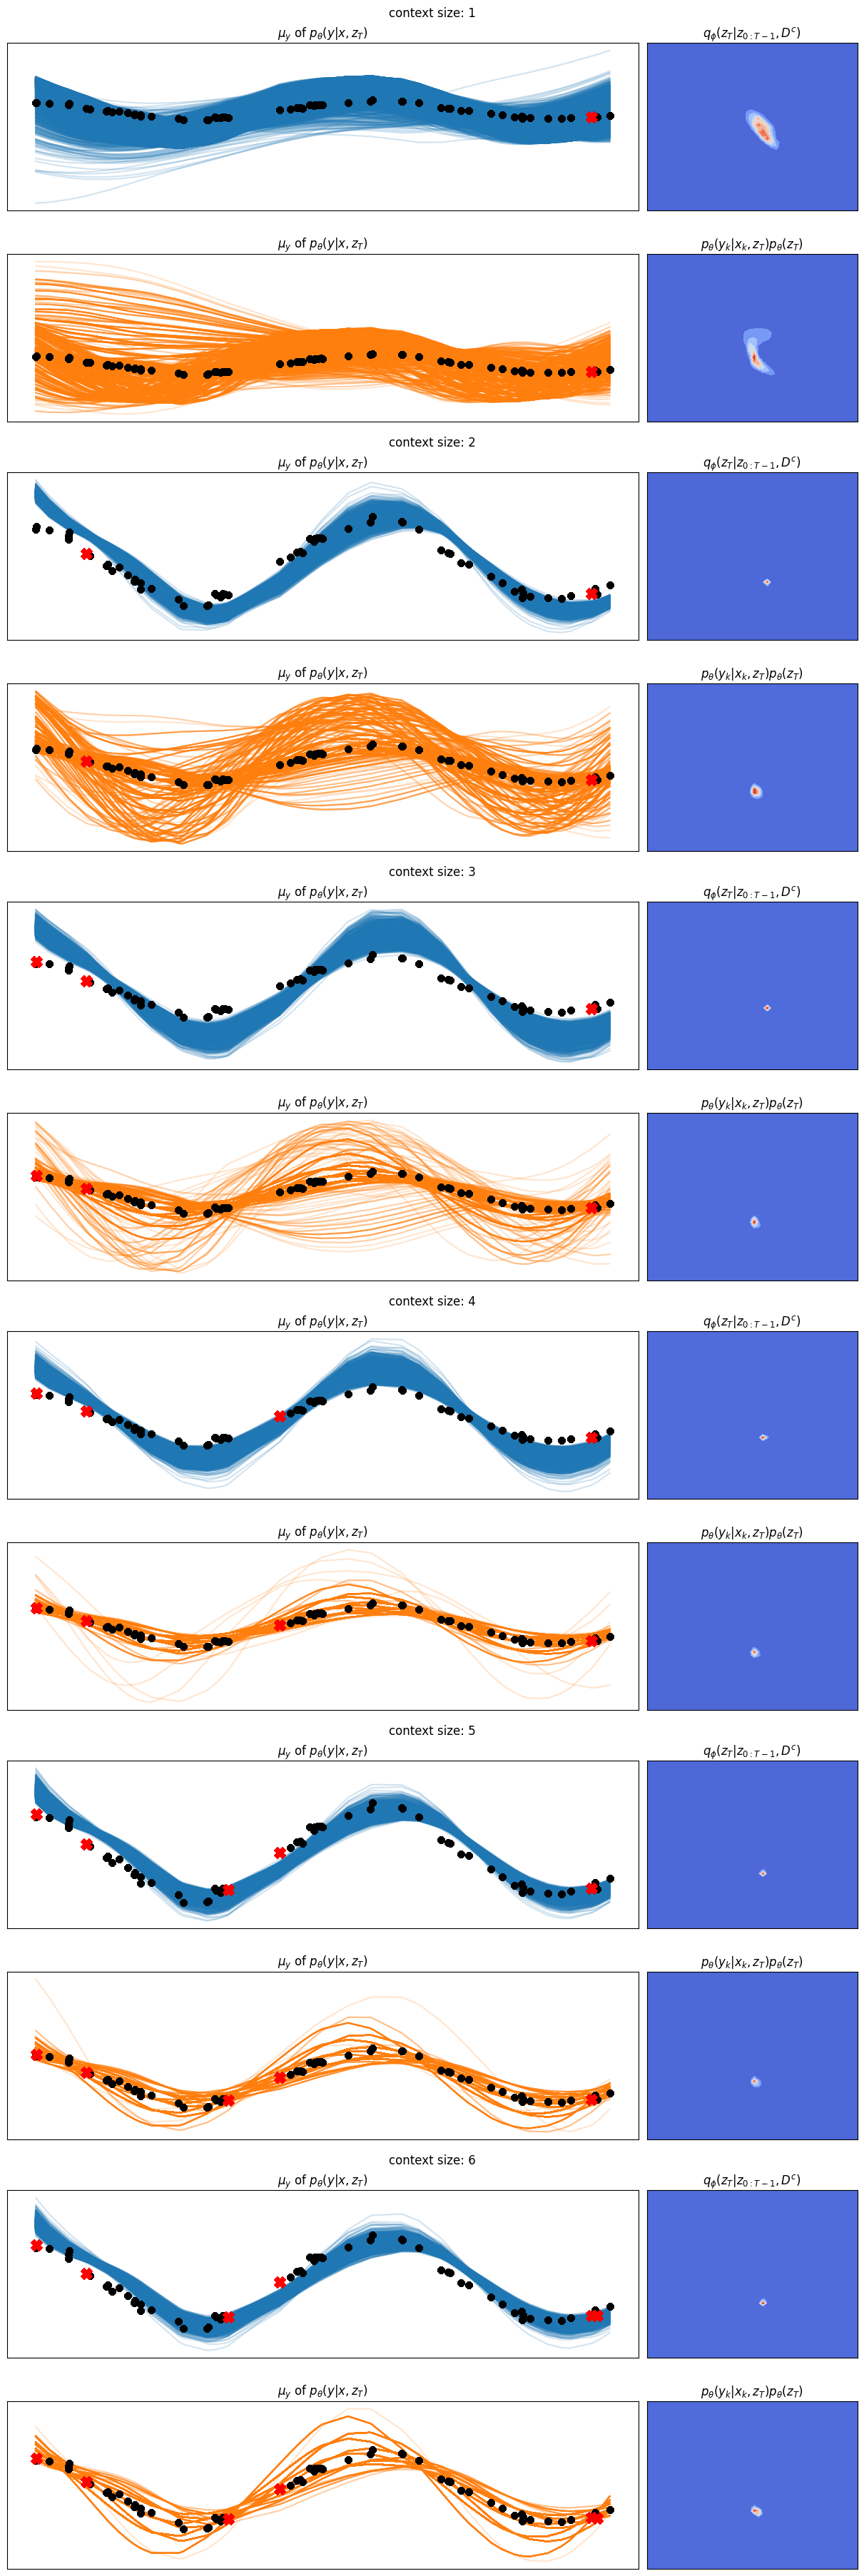

In [11]:
max_context_size = 6
num_samples = 2500 # num_cells will be root
gen_dataloader = DataLoader(trainer.val_loader.dataset, 1, True)

ranges = [(-5, 5), (-5, 5)]

targets, samples = visualize_dvinp_both(
    device=device,
    dvinp=dvinp,
    dataloader=gen_dataloader,
    num_samples=num_samples,
    max_context_size=max_context_size,
    ranges=ranges,
)

In [21]:
torch.save(dvinp.state_dict(), f"{dir}/dvinp.pth")